***Библиотеки и данные***

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor

In [2]:
data = pd.read_csv('train.csv')
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
print(open('data_description.txt').read())

MSSubClass: Identifies the type of dwelling involved in the sale.	

        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM

***Подготовка данных***

*Заполнение пропусков*

In [4]:
pd.unique(data.dtypes)

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

In [5]:
cat = []
num = []

for x in data.columns:
    if data.dtypes[x]=='object':
        cat.append(x)
    else:
        num.append(x)

In [6]:
for x in data.columns:
    nulls = data[x].isnull().sum()
    nulls_proc = nulls/data.shape[0]*100
    if nulls != 0:
        print(x, ': ', round(nulls_proc,2), '%', sep='')
        if x in cat:
            print(data[x].unique())
        print('\n')

LotFrontage: 17.74%


Alley: 93.77%
[nan 'Grvl' 'Pave']


MasVnrType: 0.55%
['BrkFace' 'None' 'Stone' 'BrkCmn' nan]


MasVnrArea: 0.55%


BsmtQual: 2.53%
['Gd' 'TA' 'Ex' nan 'Fa']


BsmtCond: 2.53%
['TA' 'Gd' nan 'Fa' 'Po']


BsmtExposure: 2.6%
['No' 'Gd' 'Mn' 'Av' nan]


BsmtFinType1: 2.53%
['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' nan 'LwQ']


BsmtFinType2: 2.6%
['Unf' 'BLQ' nan 'ALQ' 'Rec' 'LwQ' 'GLQ']


Electrical: 0.07%
['SBrkr' 'FuseF' 'FuseA' 'FuseP' 'Mix' nan]


FireplaceQu: 47.26%
[nan 'TA' 'Gd' 'Fa' 'Ex' 'Po']


GarageType: 5.55%
['Attchd' 'Detchd' 'BuiltIn' 'CarPort' nan 'Basment' '2Types']


GarageYrBlt: 5.55%


GarageFinish: 5.55%
['RFn' 'Unf' 'Fin' nan]


GarageQual: 5.55%
['TA' 'Fa' 'Gd' nan 'Ex' 'Po']


GarageCond: 5.55%
['TA' 'Fa' nan 'Gd' 'Po' 'Ex']


PoolQC: 99.52%
[nan 'Ex' 'Fa' 'Gd']


Fence: 80.75%
[nan 'MnPrv' 'GdWo' 'GdPrv' 'MnWw']


MiscFeature: 96.3%
[nan 'Shed' 'Gar2' 'Othr' 'TenC']




В фичах, где вариант отсутствующего значения предусмотен, заменяем nan на строку 'NA' (0 в случае LotFrontage), в остальных случаях пропуски заполяем модой/медианой

In [7]:
data['LotFrontage'] = data['LotFrontage'].replace(np.nan, 0)

In [8]:
data['MasVnrType'] = data['MasVnrType'].replace(np.nan, data['MasVnrType'].mode()[0])

In [9]:
data['MasVnrArea'] = data['MasVnrArea'].replace(np.nan, data['MasVnrArea'].mode()[0])

In [10]:
for x in ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']:
    data[x].replace(np.nan, 'NA')

In [11]:
ind=[]
for x,y in data['Electrical'].isnull().to_dict().items():
    if y==True:
        ind.append(x)
pd.set_option('display.max_columns', 81)
data.iloc[ind]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1379,1380,80,RL,73.0,9735,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,SLvl,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,384,384,GasA,Gd,Y,NaN,754,640,0,1394,0,0,2,1,3,1,Gd,7,Typ,0,NaN,BuiltIn,2007.0,Fin,2,400,TA,TA,Y,100,0,0,0,0,0,NaN,NaN,NaN,0,5,2008,WD,Normal,167500


In [12]:
pd.reset_option('display.max_columns')

In [13]:
data['Electrical'] = data['Electrical'].replace(np.nan, data['Electrical'].mode()[0])

In [14]:
data['GarageYrBlt'] = data['GarageYrBlt'].replace(np.nan, data['GarageYrBlt'].median())

In [15]:
for x in data.columns:
    nulls = data[x].isnull().sum()
nulls

0

*Проверка уникальности строк*

In [16]:
data.duplicated().unique()
data.duplicated(subset='Id').unique()

array([False])

*Перебор признаков*

Корреляция для количественных признаков

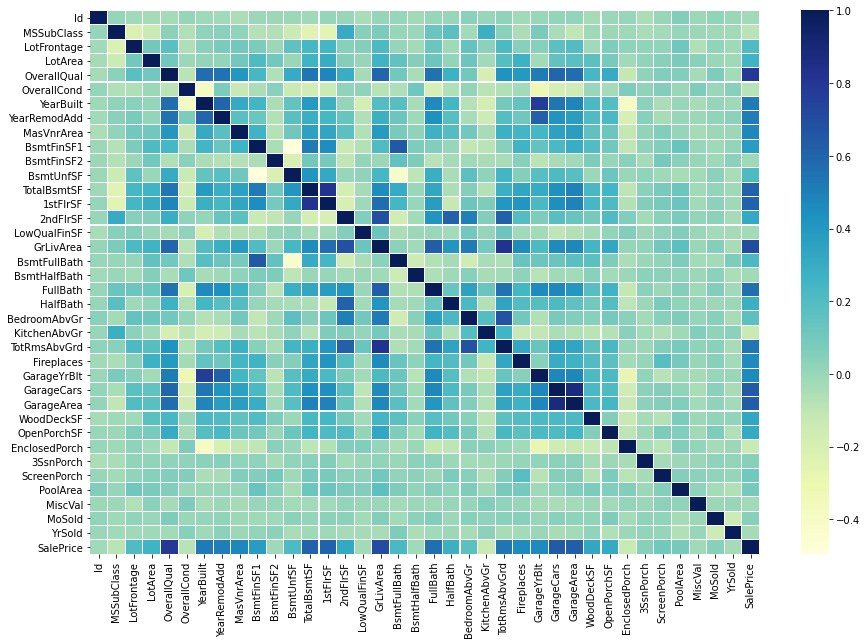

In [17]:
corr = data.corr()
plt.subplots(figsize=(15, 10))
sns.heatmap(corr, cmap='YlGnBu', linewidths=.1)

У некоторых признаков между собой присутствует объяснимая корреляция (напр. год постройки дома/год постройки гаража)

In [18]:
target_corr = data.corr()['SalePrice'].to_frame().sort_values(by='SalePrice', ascending=False)
target_corr.style.background_gradient(cmap='YlGnBu')

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897


Из числовых признаков будем использовать только 0.5+ коррелирующие с таргетом признаки

In [19]:
num_feats = list(target_corr.loc[target_corr['SalePrice']>0.5].to_dict()['SalePrice'].keys())

In [20]:
num_feats

['SalePrice',
 'OverallQual',
 'GrLivArea',
 'GarageCars',
 'GarageArea',
 'TotalBsmtSF',
 '1stFlrSF',
 'FullBath',
 'TotRmsAbvGrd',
 'YearBuilt',
 'YearRemodAdd']

In [21]:
data['YearBuilt'].corr(data['YearRemodAdd'])

0.5928549763436503

In [22]:
data['YearBuilt'].corr(data['OverallQual'])

0.5723227689623615

По тепловой карте видно, что GarageCars и GarageArea коррелируют друг с другом, поэтому оставим только признак GarageArea

1stFlrSF повторяет TotalBsmtSF, исключаем его 

FullBath и TotRmsAbvGrd идут рука об руку с общим метражом, тоже не учитываем

YearBuilt и YearRemodAdd имеют большую корреляцию между собой и с OverallQual, чем с таргетом; по логике эти признаки должны иметь вес, но вполне возможно, что они в достаточной мере учтены в общей оценке дома, пока оставим

In [23]:
for x in ['GarageCars', '1stFlrSF', 'FullBath','TotRmsAbvGrd']:
    num_feats.remove(x) 

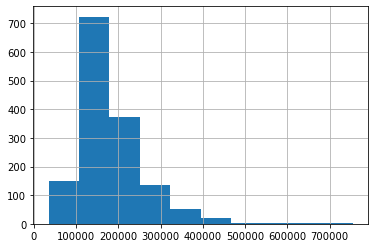

In [24]:
data['SalePrice'].hist()

In [25]:
data['SalePrice'] = np.log(data['SalePrice'])

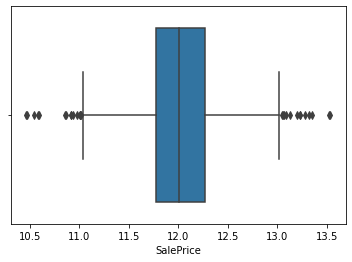

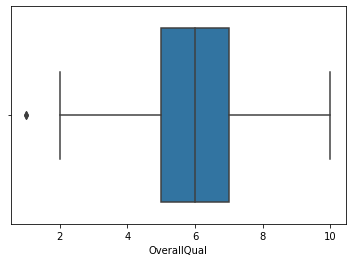

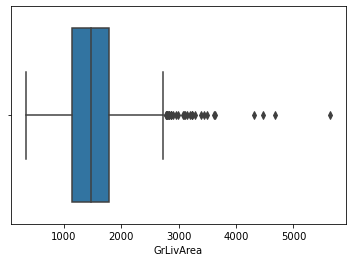

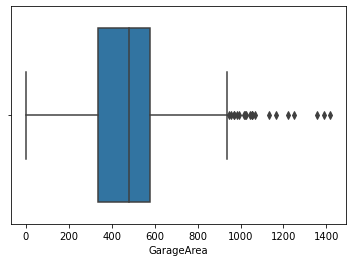

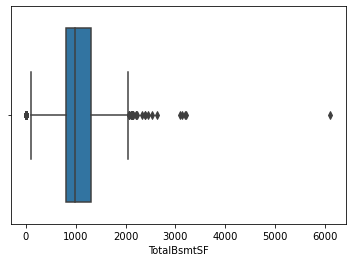

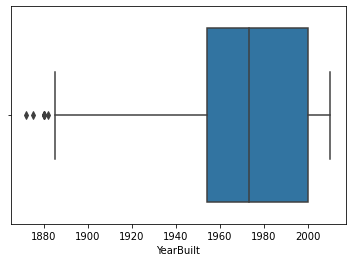

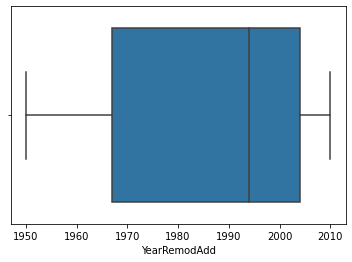

In [26]:
for x in num_feats:
    plt.show(sns.boxplot(data[x]))

In [27]:
data['SalePrice'] = data['SalePrice'].clip(10.8,13.4)

In [28]:
data['OverallQual'] = data['OverallQual'].clip(2,10)

In [29]:
data['GrLivArea'] = data['GrLivArea'].clip(0,3800)

In [30]:
data['GarageArea'] = data['GarageArea'].clip(0,1150)

In [31]:
data['TotalBsmtSF'] = data['TotalBsmtSF'].clip(100,2700)

In [32]:
data['YearBuilt'] = data['YearBuilt'].clip(1900,5000)

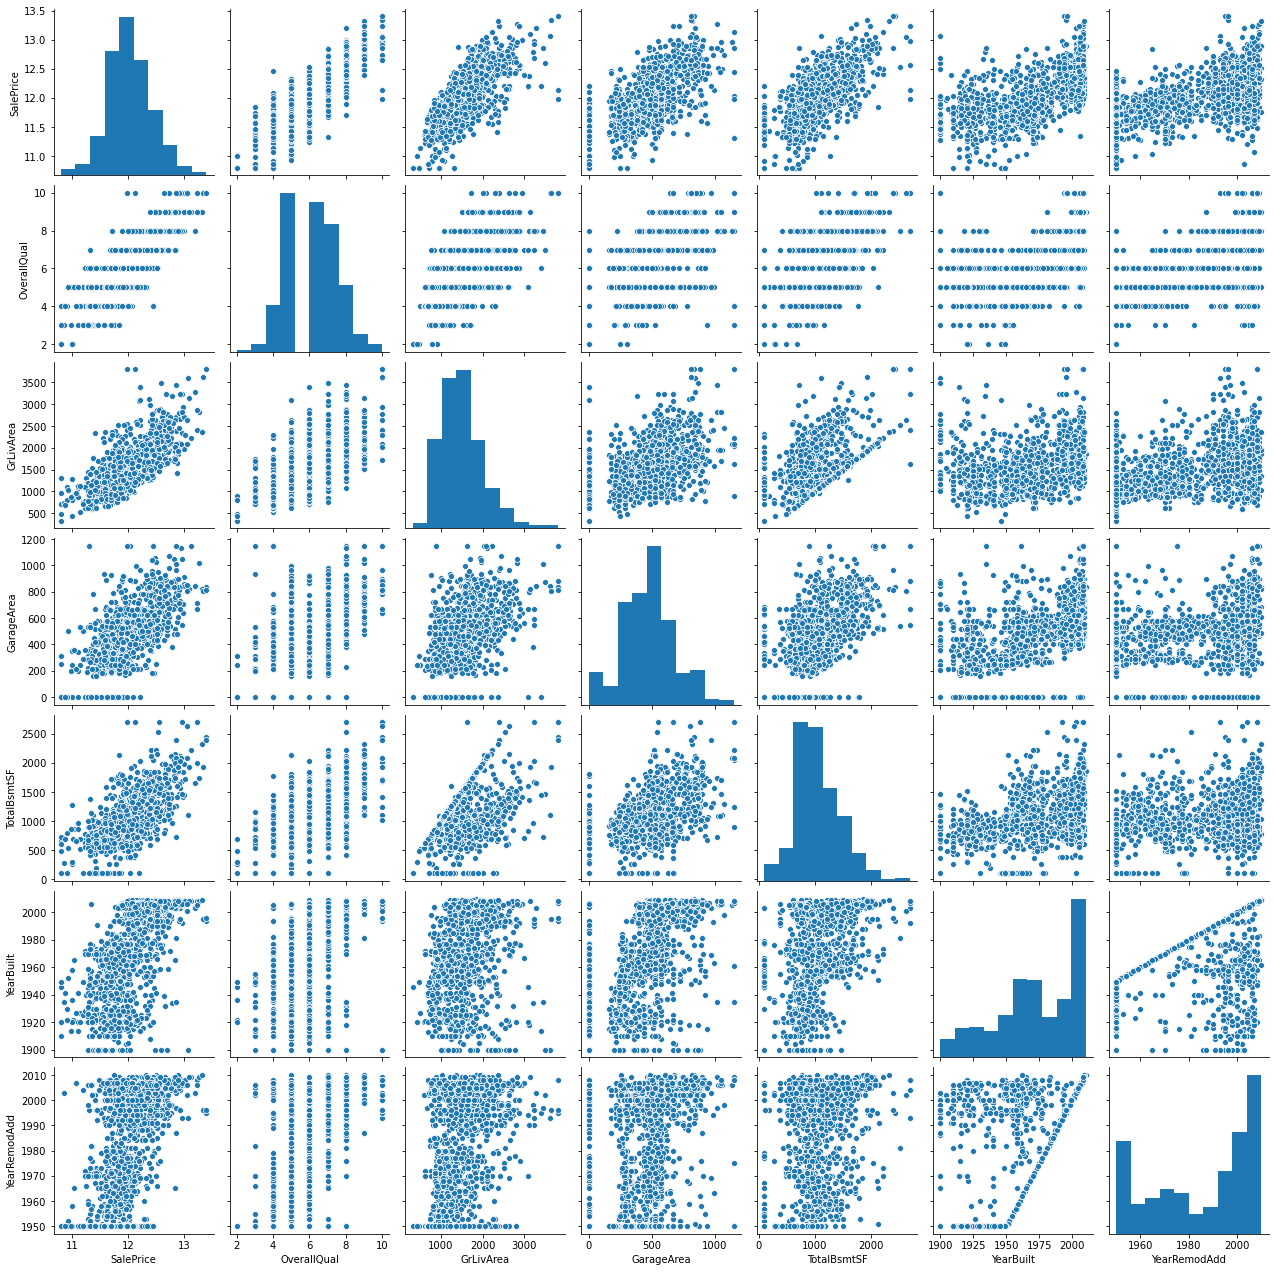

In [33]:
sns.pairplot(data[num_feats], height=2.5)

Теперь выбранные признаки очень грубо, но выглядят линейно скореелированными с целевой переменной

Разберем категориальные признаки

Поскольку мы не можем отобрать их в зависимости от корреляции, можно рискнуть дропнуть сильно не сбалансированные признаки (напр., если больше 75% это одна категория, то удаляем), а также найти по описанию и убрать те, что повторяют информацию из другого столбца (если оставнется много, рискнем отбросить незначимые по личному мнению)

In [34]:
cat_del = []

for x in cat:
    
    df_x = data[x].to_frame()
    df_x_size = df_x.groupby(x).size()
    df_x_size_prop = df_x_size.div(df_x_size.sum())
    
    for i in df_x_size_prop:
        if i > 0.75:
            cat_del.append(x)
print(cat_del, sep='')

['MSZoning', 'Street', 'LandContour', 'Utilities', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'RoofStyle', 'RoofMatl', 'ExterCond', 'BsmtCond', 'BsmtFinType2', 'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageQual', 'GarageCond', 'PavedDrive', 'MiscFeature', 'SaleType', 'SaleCondition']


In [35]:
cat_feats = cat

In [36]:
for x in cat_del:
    cat_feats.remove(x)
print(cat_feats, sep='')

['Alley', 'LotShape', 'LotConfig', 'Neighborhood', 'HouseStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'Foundation', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageType', 'GarageFinish', 'PoolQC', 'Fence']


In [37]:
for x in ['LotShape', 'MasVnrType', 'BsmtExposure', 'Exterior1st', 'Exterior2nd', 'FireplaceQu']:
        cat_feats.remove(x)

In [38]:
print(cat_feats, sep='')

['Alley', 'LotConfig', 'Neighborhood', 'HouseStyle', 'ExterQual', 'Foundation', 'BsmtQual', 'BsmtFinType1', 'HeatingQC', 'KitchenQual', 'GarageType', 'GarageFinish', 'PoolQC', 'Fence']


Данные, с которыми, исходя из обработки, должна работать модель:

In [39]:
cols = num_feats+cat_feats
data_new = data[cols]
features = cols
features.remove('SalePrice')
data_new.head()

,SalePrice,OverallQual,GrLivArea,GarageArea,TotalBsmtSF,YearBuilt,YearRemodAdd,Alley,LotConfig,Neighborhood,...,ExterQual,Foundation,BsmtQual,BsmtFinType1,HeatingQC,KitchenQual,GarageType,GarageFinish,PoolQC,Fence
0,12.247694,7,1710,548,856,2003,2003,NaN,Inside,CollgCr,...,Gd,PConc,Gd,GLQ,Ex,Gd,Attchd,RFn,NaN,NaN
1,12.109011,6,1262,460,1262,1976,1976,NaN,FR2,Veenker,...,TA,CBlock,Gd,ALQ,Ex,TA,Attchd,RFn,NaN,NaN
2,12.317167,7,1786,608,920,2001,2002,NaN,Inside,CollgCr,...,Gd,PConc,Gd,GLQ,Ex,Gd,Attchd,RFn,NaN,NaN
3,11.849398,7,1717,642,756,1915,1970,NaN,Corner,Crawfor,...,TA,BrkTil,TA,ALQ,Gd,Gd,Detchd,Unf,NaN,NaN
4,12.429216,8,2198,836,1145,2000,2000,NaN,FR2,NoRidge,...,Gd,PConc,Gd,GLQ,Ex,Gd,Attchd,RFn,NaN,NaN


***Окончательный выбор признаков для модели***

Прогоним весь изначальный датасет через RandomForestRegressor, чтобы посмотреть, какие признаки он посчитает наиболее важными

In [40]:
X = pd.get_dummies(data.drop(columns='SalePrice'))
y = data['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
model = RandomForestRegressor()

model.fit(X_train, y_train)
model.score(X_test, y_test)

0.8735914326287036

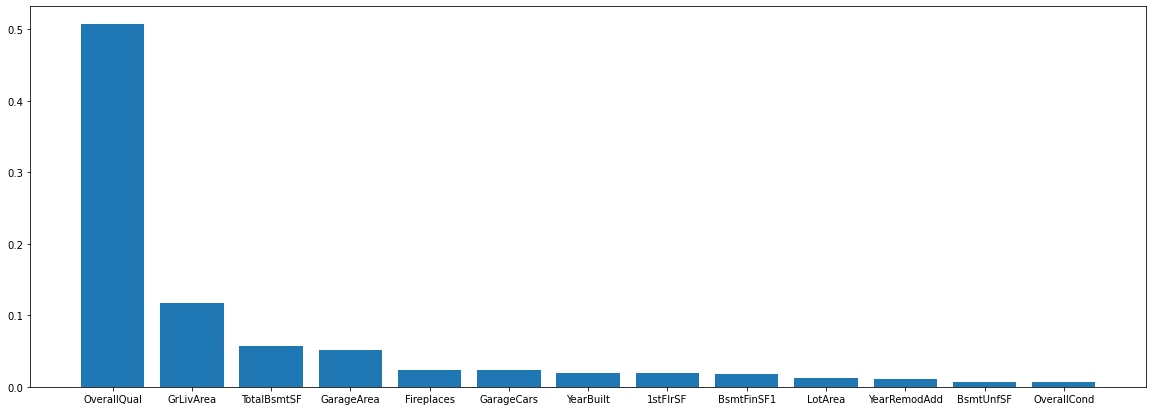

In [41]:
importances = model.feature_importances_
N = len(features)

f_index = np.argsort(importances)[::-1][:N]
fs = {}
for x in range(len(X.columns)):
    fs[x] = X.columns[x]

RF_features = [fs[i] for i in f_index]

plt.figure(figsize=(20, 7))
plt.bar(range(13), importances[f_index][:13])
plt.xticks(range(13), RF_features[:13])
plt.show()

Наиболее значимые признаки совпадают

***RandomForestRegressor***

Потестим RandomForestRegressor на наших данных

In [42]:
data_new = data_new[features]

In [43]:
X = pd.get_dummies(data_new)
y = data['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
model = RandomForestRegressor()

model.fit(X_train, y_train)
model.score(X_test, y_test)

0.8190218444211076

Уточним оценку модели:

In [44]:
score = cross_val_score(model, X, y, cv=10)
np.mean(score)

0.856593048169999

***Стекинг***

In [45]:
base_models = [('LR', LinearRegression()), ('kNR', KNeighborsRegressor()), ('DTR', DecisionTreeRegressor())]
meta_model = GradientBoostingRegressor()

model = StackingRegressor(base_models, meta_model)

models = dict(base_models)
models['stack'] = meta_model

for name, model in models.items():
    scores = cross_val_score(model, X, y)
    print(name, round(np.mean(scores), 3))

LR 0.873
kNR 0.743
DTR 0.725
stack 0.874
